# Create, evaluate, and score a time series forecasting model

Modified from https://github.com/microsoft/fabric-samples/blob/main/docs-samples/data-science/ai-samples/python/AIsample%20-%20Time%20Series%20Forecasting.ipynb

## Introduction

This notebook shows the Microsoft Fabric end-to-end data science workflow for a time series forecasting model. This scenario uses historic sales data to predict the total monthly sales of properties in New York City.

Time series forecasting predicts future values, based on historical data. This is a common, important part of business operations. This notebook shows tools and methods that can apply to other forecasting tasks: weather, sales numbers, stock prices, capacity planning, etc. 

This notebook covers these topics:

1. Install custom library resources
2. Load the data
3. Examine and process the data through exploratory data analysis
4. Train a machine learning model with `Prophet` - an open source software package - and track experiments using MLflow and the Fabric Autologging feature
5. Save the final machine learning model, and make predictions

## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You'll download data from a public blob, then store the data in the lakehouse.


## Step 1: Install custom libraries


When you develop a machine learning model, or you handle ad-hoc data analysis, you may need to quickly install a custom library (e.g., `prophet` in this notebook) for the Apache Spark session. To do this, you have two choices. 

1. You can use the in-line installation capabilities (e.g., `%pip`, `%conda`, etc.) to quickly get started with new libraries. Note that this would only install the custom libraries in the current notebook, not in the workspace.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
```

2. Alternatively, you can create a Fabric environment, install libraries from public sources or upload custom libraries to it, and then your workspace admin can attach the environment as the default for the workspace. All the libraries in the environment will then become available for use in any notebooks and Spark job definitions in the workspace. For more information on environments, see [create, configure, and use an environment in Microsoft Fabric](https://aka.ms/fabric/create-environment).


For this notebook, you'll use `%pip install` to install the `prophet` library. Note that the PySpark kernel will restart after `%pip install`. This means that you must install the library before you run any other cells.

In [18]:
# Use pip to install Prophet
%pip install prophet

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 36, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



## Step 2: Load the data

#### Dataset

Manually Generated dataset showing costs per month for a fictional business, CSVs generated from Python using GitHub Copilot to write the code

#### Download the dataset, and upload to a lakehouse

Prepared data was loaded from desktop environment to pre-existing Fabric lakehouse, using the upload files to load files to Files section, and then the "load to Tables" UI shortcut to load to a table.




> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

Start recording the run-time of this notebook.

In [19]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 38, Finished, Available, Finished)

#### Set up the MLflow experiment tracking

To extend the MLflow logging capabilities, autologging automatically captures the values of input parameters and output metrics of a machine learning model during its training. This information is then logged to the workspace, where the MLflow APIs or the corresponding experiment in the workspace can access and visualize it. Visit [this resource](https://aka.ms/fabric-autologging) for more information about autologging.

In [20]:
# Set up the MLflow experiment
import mlflow

EXPERIMENT_NAME = "opex_experi" # MLflow experiment name

mlflow.set_experiment(EXPERIMENT_NAME) 
mlflow.autolog(disable=True)  # Disable MLflow autologging

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 39, Finished, Available, Finished)

> [!NOTE]
> If you want to disable Microsoft Fabric autologging in a notebook session, call `mlflow.autolog()` and set `disable=True`.

#### Read raw date data from the lakehouse

In [21]:
df = spark.sql("SELECT * FROM lh_FinForecast.opex_set1")

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 40, Finished, Available, Finished)

## Step 3: Begin exploratory data analysis

To review the dataset, you could manually examine a subset of data to gain a better understanding of it. You can use the `display` function to print the DataFrame. You can also show the Chart views, to easily visualize subsets of the dataset.

In [22]:
display(df)

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 41, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d4b02d51-2ce8-46b9-b6f5-b26c98526da0)

A manual review of the dataset leads to some early observations:
Use the inspect


#### Type conversion and filtering
To resolve some of the identified issues, import the required libraries.

In [23]:
# Import libraries
import pyspark.sql.functions as F
from pyspark.sql.types import *

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 42, Finished, Available, Finished)

#### Pyspark to Pandas conversion

Pyspark DataFrames handle large datasets really well. However, due to data aggregation, the DataFrame size is much smaller. This suggests that you can now use pandas DataFrames.

This code casts the dataset from a pyspark DataFrame to a pandas DataFrame.

In [24]:
import pandas as pd

df_pandas = df.toPandas()
display(df_pandas)

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 43, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a19ca8c5-ae15-4a4f-83d1-851b448332c6)

#### Visualization

You can examine the property trade trend of New York City to better understand the data. This leads to insights into potential patterns and seasonality trends. Learn more about Microsoft Fabric data visualization at [this](https://aka.ms/fabric/visualization) resource.

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 44, Finished, Available, Finished)

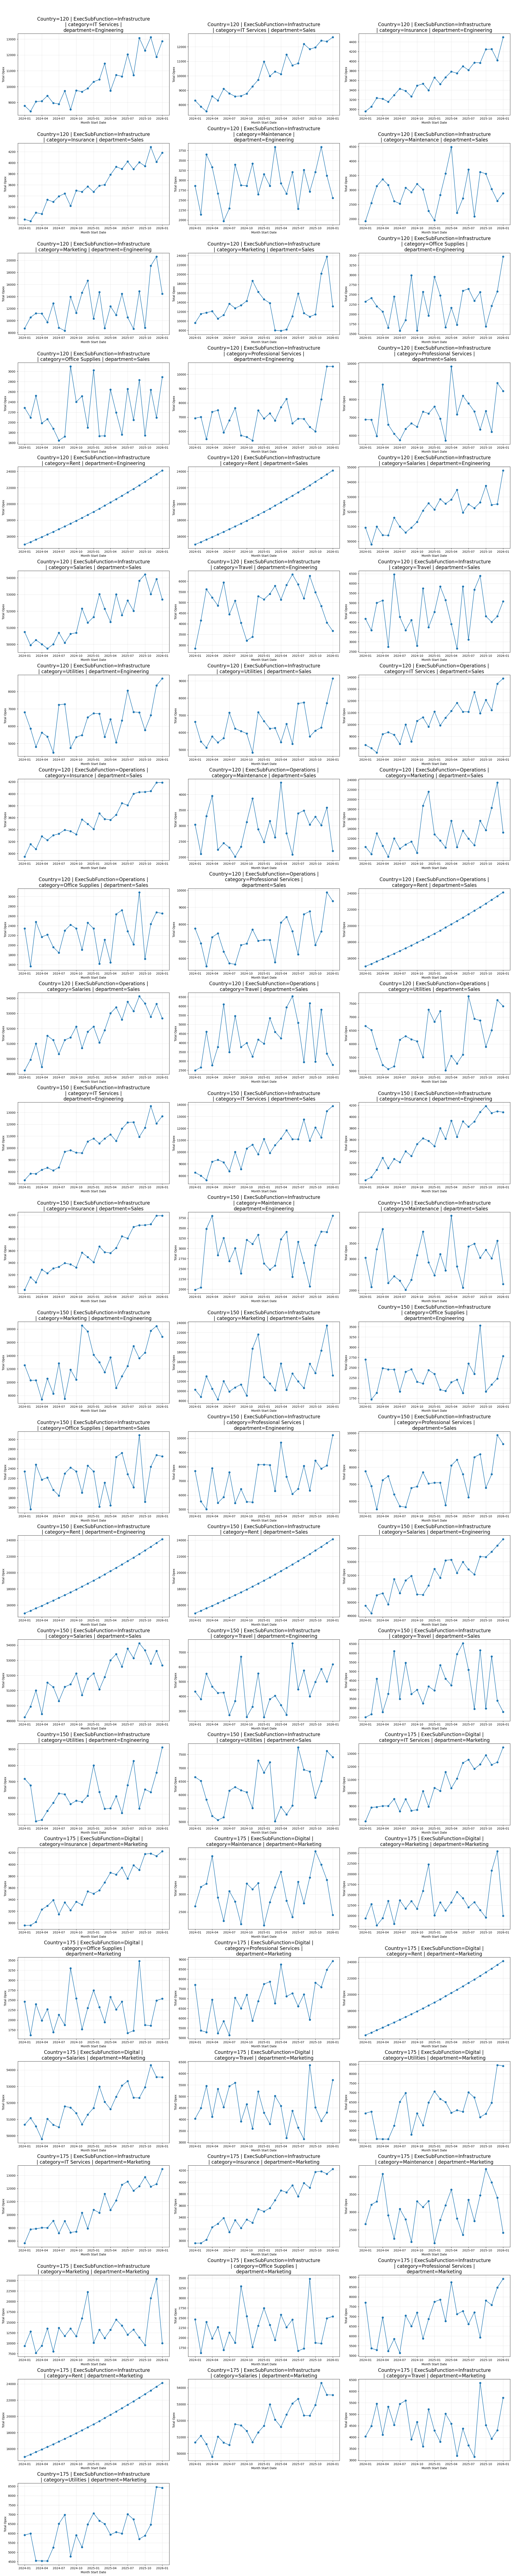

In [25]:
#### ATTENTION: AI-generated code can include errors or operations you didn't intend. Review the code in this cell carefully before running it.

# Visualization using matplotlib (dark background) with wrapped chart titles per group

import matplotlib.pyplot as plt
import numpy as np
import textwrap

# Ensure date column is datetime and sorted
if 'date' in df_pandas.columns:
    df_pandas = df_pandas.copy()
    df_pandas['date'] = pd.to_datetime(df_pandas['date'])
    df_pandas = df_pandas.sort_values('date')

# Prepare plotting: One subplot per group
grouping_columns = ['Country', 'ExecSubFunction', 'category', 'department']
grouping_columns_present = [col for col in grouping_columns if col in df_pandas.columns]

if not grouping_columns_present:
    raise ValueError("At least one of the following columns must exist in df_pandas: " + str(grouping_columns))

groups = df_pandas.groupby(grouping_columns_present)

n_groups = len(groups)
fig_rows = min(25, n_groups)
fig_cols = int(np.ceil(n_groups / fig_rows))

fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(8 * fig_cols, 5 * fig_rows), constrained_layout=True)
axes = np.array(axes).reshape(-1)

plt.style.use('dark_background')

title_wrap_width = 45  # Adjust for break length

for i, (group_keys, group_df) in enumerate(groups):
    if isinstance(group_keys, tuple):
        group_label_raw = " | ".join(f"{col}={val}" for col, val in zip(grouping_columns_present, group_keys))
    else:
        group_label_raw = f"{grouping_columns_present[0]}={group_keys}"

    # Wrap title
    group_label = "\n".join(textwrap.wrap(group_label_raw, width=title_wrap_width))

    ax = axes[i]
    group_df_by_month = group_df.groupby('date')['amount'].sum().reset_index()
    ax.plot(group_df_by_month['date'], group_df_by_month['amount'], marker='o')
    ax.set_title(group_label, fontsize=16)
    ax.set_xlabel('Month Start Date')
    ax.set_ylabel('Total Opex')
    ax.grid(alpha=0.3)

# Remove unused axes (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Total Opex by Month\n(separated by: ' + ", ".join(grouping_columns_present) + ')', fontsize=20)
plt.show()

#### Summary of observations from the exploratory data analysis

Put observations here

## Step 4: Model training and tracking

### Model fitting

[Prophet](https://facebook.github.io/prophet/) input is always a two-column DataFrame. One input column is a time column named `ds`, and one input column is a value column named `y`. The time column should have a date, time, or datetime data format (e.g., `YYYY_MM`). The dataset here meets that condition. The value column must be a numerical data format.

For the model fitting, you must only rename the time column to `ds` and value column to `y`, and pass the data to Prophet. Read the [Prophet Python API documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api) for more information.

In [26]:
df_pandas["ds"] = pd.to_datetime(df_pandas["date"])
df_pandas["y"] = df_pandas["amount"]

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 45, Finished, Available, Finished)

Prophet follows the [scikit-learn](https://scikit-learn.org/) convention. First, create a new instance of Prophet, set certain parameters (e.g.,`seasonality_mode`), and then fit that instance to the dataset.

- Although a constant additive factor is the default seasonality effect for Prophet, you should use the **'multiplicative' seasonality** for the seasonality effect parameter. The analysis in the previous section showed that because of changes in seasonality amplitude, a simple additive seasonality won't fit the data well at all.

- Set the **weekly_seasonality** parameter to **off**, because the data was aggregated by month. As a result, weekly data is not available.

- Use **Markov Chain Monte Carlo (MCMC)** methods to capture the seasonality uncertainty estimates. By default, Prophet can provide uncertainty estimates on the trend and observation noise, but not for the seasonality. MCMC require more processing time, but they allow the algorithm to provide uncertainty estimates on the seasonality, as well as the trend and observation noise. Read the [Prophet Uncertainty Intervals documentation](https://facebook.github.io/prophet/docs/uncertainty_intervals.html) for more information.

- Tune the automatic change point detection sensitivity through the **changepoint_prior_scale** parameter. The Prophet algorithm automatically tries to find instances in the data where the trajectories abruptly change. It can become difficult to find the correct value. To resolve this, you can try different values and then select the model with the best performance. Read the [Prophet Trend Changepoints documentation](https://facebook.github.io/prophet/docs/trend_changepoints.html) for more information.


In [27]:


# Modified OPEX Prophet Forecast - Works with a passed-in DataFrame (df_pandas)
# You: pass in your DataFrame and (optionally) set the number of forecast periods.


import pandas as pd
from prophet import Prophet
from typing import Optional, List, Tuple

import warnings
warnings.filterwarnings('ignore')


def get_group_combinations(df: pd.DataFrame) -> List[Tuple]:
    """Get unique combinations of department, ExecSubFunction, Country."""
    group_cols = []
    if 'department' in df.columns:
        group_cols.append('department')
    if 'ExecSubFunction' in df.columns:
        group_cols.append('ExecSubFunction')
    if 'Country' in df.columns:
        group_cols.append('Country')
    if not group_cols:
        return [('all',)]    
    return df[group_cols].drop_duplicates().values.tolist()


def forecast_group(
    df: pd.DataFrame,
    periods: int = 6,
    group_filter: Optional[dict] = None
) -> pd.DataFrame:
    """
    Forecast spending for a specific group using Prophet.
    
    Args:
        df: DataFrame with date and amount columns
        periods: Number of months to forecast
        group_filter: Dict of column->value filters (e.g., {'department': 'Engineering'})
    
    Returns:
        DataFrame with forecast results
    """
    filtered_df = df.copy()
    if group_filter:
        for col, val in group_filter.items():
            if col in filtered_df.columns:
                filtered_df = filtered_df[filtered_df[col] == val]
    # Aggregate by date (sum all categories)
    daily_totals = filtered_df.groupby('date')['amount'].sum().reset_index()
    daily_totals.columns = ['ds', 'y']
    daily_totals['ds'] = pd.to_datetime(daily_totals['ds'])
    if len(daily_totals) < 2:
        print(f"  Insufficient data for forecasting (only {len(daily_totals)} records)")
        return pd.DataFrame()
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )
    model.fit(daily_totals)
    future = model.make_future_dataframe(periods=periods, freq='MS')
    forecast = model.predict(future)
    # Add group info to results
    if group_filter:
        for col, val in group_filter.items():
            forecast[col] = val
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper'] + list(group_filter.keys() if group_filter else [])]


def forecast_all_groups(
    df: pd.DataFrame,
    periods: int = 6
) -> pd.DataFrame:
    """
    Forecast spending for all department/ExecSubFunction/Country combinations.
    Args:
        df: Combined DataFrame with all OPEX data
        periods: Number of months to forecast
    Returns:
        DataFrame with forecasts for all groups
    """
    group_cols = []
    if 'department' in df.columns:
        group_cols.append('department')
    if 'ExecSubFunction' in df.columns:
        group_cols.append('ExecSubFunction')
    if 'Country' in df.columns:
        group_cols.append('Country')
    if 'category' in df.columns:
        group_cols.append('category')
    if not group_cols:
        print("No grouping columns found, forecasting total spend")
        return forecast_group(df, periods)
    combinations = df[group_cols].drop_duplicates().to_dict('records')
    all_forecasts = []
    for i, combo in enumerate(combinations, 1):
        combo_str = " | ".join(f"{k}={v}" for k, v in combo.items())
        print(f"[{i}/{len(combinations)}] Forecasting: {combo_str}")
        forecast = forecast_group(df, periods, combo)
        if not forecast.empty:
            all_forecasts.append(forecast)
    if not all_forecasts:
        return pd.DataFrame()
    return pd.concat(all_forecasts, ignore_index=True)


def run_forecast_pipeline(
    df_pandas: pd.DataFrame,
    periods: int = 6
) -> pd.DataFrame:
    """
    Run the forecasting pipeline. 
    Supply: a pandas DataFrame and (optionally) the number of months to forecast.
    Returns: DataFrame of future forecasts (only periods ahead, not historical).
    """
    if not isinstance(df_pandas, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    if 'date' not in df_pandas.columns or 'amount' not in df_pandas.columns:
        raise ValueError("DataFrame must contain 'date' and 'amount' columns.")
    df_pandas['date'] = pd.to_datetime(df_pandas['date'])
    forecasts = forecast_all_groups(df_pandas, periods)
    if forecasts.empty:
        print("No forecasts generated")
        return pd.DataFrame()
    max_historical_date = df_pandas['date'].max()
    future_forecasts = forecasts[forecasts['ds'] > max_historical_date].copy()
    future_forecasts = future_forecasts.rename(columns={
        'ds': 'date',
        'yhat': 'forecast_amount',
        'yhat_lower': 'forecast_lower',
        'yhat_upper': 'forecast_upper'
    })
    for col in ['forecast_amount', 'forecast_lower', 'forecast_upper']:
        future_forecasts[col] = future_forecasts[col].round(2)
    print(f"\nForecast Results: {len(future_forecasts)} rows (future months only)")
    print(future_forecasts.head(10).to_string(index=False))
    return future_forecasts

# Example usage:
# results_df = run_forecast_pipeline(df_pandas, periods=6)
# results_df.head()

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 46, Finished, Available, Finished)

In [28]:
results_df = run_forecast_pipeline(df_pandas, periods=6)
results_df.head()

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 47, Finished, Available, Finished)

[1/70] Forecasting: department=Sales | ExecSubFunction=Operations | Country=120 | category=Salaries
[2/70] Forecasting: department=Engineering | ExecSubFunction=Infrastructure | Country=150 | category=IT Services
[7/70] Forecasting: department=Sales | ExecSubFunction=Infrastructure | Country=120 | category=Utilities
[8/70] Forecasting: department=Engineering | ExecSubFunction=Infrastructure | Country=120 | category=Salaries
[10/70] Forecasting: department=Engineering | ExecSubFunction=Infrastructure | Country=120 | category=Utilities
[11/70] Forecasting: department=Engineering | ExecSubFunction=Infrastructure | Country=150 | category=Salaries
[12/70] Forecasting: department=Engineering | ExecSubFunction=Infrastructure | Country=120 | category=Rent
[15/70] Forecasting: department=Engineering | ExecSubFunction=Infrastructure | Country=120 | category=Travel
[16/70] Forecasting: department=Engineering | ExecSubFunction=Infrastructure | Country=120 | category=IT Services
[17/70] Forecasting

16:19:06 - cmdstanpy - INFO - Chain [1] done processing
16:19:06 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:07 - cmdstanpy - INFO - Chain [1] start processing
16:21:47 - cmdstanpy - INFO - Chain [1] done processing
16:21:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing


date  forecast_amount  forecast_lower  forecast_upper department  \
25 2026-02-01         51868.05        51848.04        51888.47      Sales   
26 2026-03-01         51086.07        51019.16        51154.79      Sales   
27 2026-04-01         54504.57        54365.46        54639.31      Sales   
28 2026-05-01         52707.13        52488.13        52904.83      Sales   
29 2026-06-01         50980.18        50687.62        51263.29      Sales   

   ExecSubFunction  Country  category  
25      Operations      120  Salaries  
26      Operations      120  Salaries  
27      Operations      120  Salaries  
28      Operations      120  Salaries  
29      Operations      120  Salaries

In [29]:
display (results_df)

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 48, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, edd370d7-54c5-49c7-a581-aa472009c6a8)

In [30]:
#### ATTENTION: AI-generated code can include errors or operations you didn't intend. Review the code in this cell carefully before running it.

from datetime import datetime

# Add a current date and time column and a constant 'source' column to results_df
current_dt = datetime.now()

results_df['current_datetime'] = current_dt
results_df['source'] = "prophet forecast"

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 49, Finished, Available, Finished)

In [31]:
display(results_df)

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 50, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f624ae0f-b34f-400f-b13a-2a0caae3ceb8)

In [34]:
import pandas as pd

if isinstance(results_df, pd.DataFrame):
    spark_results_df = spark.createDataFrame(results_df)
else:
    spark_results_df = results_df

spark_results_df.write.format("delta").mode("append").saveAsTable("opex_forecasts")

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 53, Finished, Available, Finished)

In [35]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 07be1f15-76c4-4e2a-b56d-3fb939b7eda8, 54, Finished, Available, Finished)

Full run cost 1580 seconds.
